In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
import scipy.io
from mpl_toolkits.mplot3d import Axes3D
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go

init_notebook_mode(connected=True)

sns.set()
sns.set_style("white")

%matplotlib inline

## Motor planning module (MPM) implementation

In [7]:
def thresh_exp(x):
    '''Activation function'''
    return 1 / (1 + np.exp(-x))

In [8]:
PARAMS_DICT = {'Wut': 6,
              'Wuv': 6,
              'Wvt': 6,
              'Wvu': 6,
              'dt': 10,
              'tau': 100,
              'ext': 0,
              'y0': 0.7,
              'K': 8.0,
              'sigma': 0.05,
              'alpha': 1}

In [9]:
def production_model(state_init, params, niter):
    '''
    Inputs:
    state_init: an array which includes:
        * I: initial current
        * u: initial state of u
        * v: initial state of v
        * y: initial state of y (readout neuron)
        * sig: state indicator (0 or 1)
        
    params: a dictionary of relevant parameters
    niter: number of iterations
    
    Outputs: each list contains niter elements
    u_lst: list of u activities 
    v_lst: list of v activities
    y_lst: list of y activities
    I_lst: list of I activities
    sig_lst: list of sig in this simulation
        
    '''
    
    # Unpack parameters of the simulation
    Wut = params['Wut']
    Wuv = params['Wut']
    Wvt = params['Wut']
    Wvu = params['Wut']
    dt = params['dt']
    tau = params['tau']
    ext = params['ext']
    y0 = params['y0'] #The target (threshold) value of y
    K = params['K']
    sigma = params['sigma']
    alpha = params['alpha']
    
    # Unpack variables
    I, u, v, y, sig = state_init
    
    ntrials = len(I)
    
    IP = I.copy()
    uP = u.copy()
    vP = v.copy()
    yP = y.copy()
    
    u_p = []
    v_p = []
    y_p = []
    I_p = []
    production_lst = []
    
    for i in range(niter):
        
        
        # u-v and y update
        sigP = (yP >= y0).astype('float')
        uP += (-uP + thresh_exp(Wut * IP - Wuv * vP - 50 * sigP + np.random.randn(ntrials) * sigma)) / tau * dt
        vP += (-vP + thresh_exp(Wvt * IP - Wvu * uP + 50 * sigP + np.random.randn(ntrials) * sigma)) / tau * dt

        yP += (-yP + uP - vP + np.random.randn(ntrials) * sigma) / 100 * dt
        
        IP = I.copy()
        #print((yP.copy() - yS.copy()))
        #IP = I.copy() - gauss_derivative((yP.copy() - yS.copy()),0.4,alpha)

        v_p.append(vP.copy())
        u_p.append(uP.copy())
        y_p.append(yP.copy())
        I_p.append(IP.copy())
        production_lst.append(sigP)
        
    return u_p, v_p, y_p, I_p, production_lst

def simulate_production(ntrials=1, duration = 10000, sigma=0, initI=0.7):
    # Initial run
    #ntrials = 1000
    #duration = 600 #ms
    #nstages = 10
    PARAMS_DICT['sigma'] = sigma
    PARAMS_DICT['K'] = 2
    PARAMS_DICT['alpha'] = 0.1
    
    nbin = int(np.divide(duration,PARAMS_DICT['dt']))
    #print(nbin)
    state_init = [np.ones(ntrials) * initI, 
                  np.ones(ntrials) * 0.87, 
                  np.ones(ntrials) * 0.25,
                  np.ones(ntrials) * 0.5,
                  0.0]

    u_p, v_p, y_p, I_p, production_lst = production_model(state_init, PARAMS_DICT, nbin)


    return u_p, v_p, y_p, I_p, production_lst 

## MPM simulations

0
4000
1
4000
2
4000
3
4000


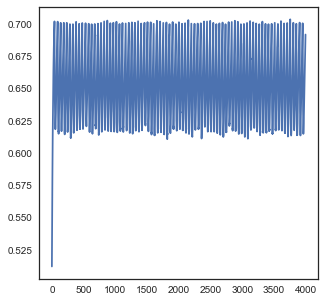

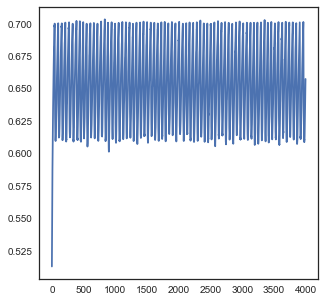

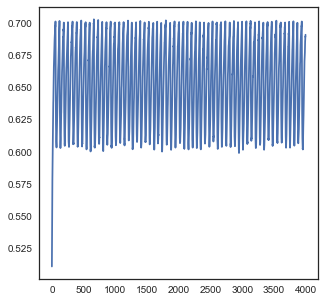

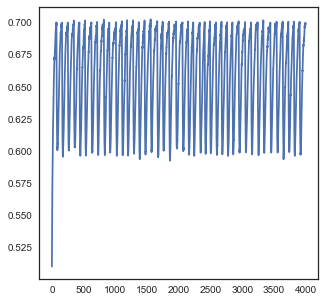

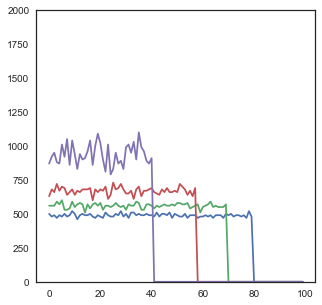

In [10]:
dur = 40000
nI = 4
Ilst = np.linspace(0.75,0.78, nI)
ipi = np.zeros((nI,100))
ulst = np.zeros((nI,int(dur/PARAMS_DICT['dt'])))
vlst = np.zeros((nI,int(dur/PARAMS_DICT['dt'])))
ylst = np.zeros((nI,int(dur/PARAMS_DICT['dt'])))
pressT = np.zeros((nI,100))
for i in range(nI):
    print(i)
    u_p, v_p, y_p, I_p, production_lst = simulate_production(ntrials=1, duration = dur, sigma=0.01, initI=Ilst[i])
    
    press_times = np.multiply(np.nonzero(production_lst),PARAMS_DICT['dt'])
    
    pressT[i,:np.size(press_times[0,:])] = press_times[0,:]
    ipi[i,:np.size(press_times[0,:])-1] = np.diff(press_times[0,:])
    print(len(u_p))
    ulst[i,:] = u_p
    vlst[i,:] = v_p
    ylst[i,:] = y_p
    plt.figure(figsize=(5, 5))
    plt.plot(y_p)

x = {}
x['ulst'] = ulst
x['vlst'] = vlst
x['ylst'] = ylst
x['Ilst'] = Ilst
x['ipi'] = ipi
x['pressT'] = pressT
scipy.io.savemat('productionData_many.mat',x)
plt.figure(figsize=(5,5))
for i in range(nI):
    plt.plot(ipi[i,:])
    plt.ylim(0,2000)